In [ ]:
pip install ucimlrepo

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from ucimlrepo import fetch_ucirepo 

#%% load Wisconsin Breast Cancer dataset using ucimlrepo
# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets

print(X.dtypes)
print(y.dtypes)

In [5]:
#%% analyse features
target = y['Diagnosis']
counter = Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%s, Count=%d, Percentage=%.3f%%' % (k, v, per))

Class=M, Count=212, Percentage=37.258%
Class=B, Count=357, Percentage=62.742%


In [ ]:
#%% convert categorical labesl to integer
label_map={'M':1, 'B':0}
y['Diagnosis']=y['Diagnosis'].map(label_map).astype(int)

In [8]:
#%% split train and test sets
X = X.to_numpy()
y = y.to_numpy()
y = np.squeeze(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

#%% model: logistic regression
model = LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000)
model.fit(X_train, y_train)
model.score(X_train, y_train)

# accuracy = 0.955078125

0.955078125

In [9]:
#%% standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000)
model.fit(X_train, y_train)
model.score(X_train, y_train)

# accuracy = 0.98828125

0.98828125

In [18]:
#%% tune various hyperparameters using GridSearchCV()
from sklearn.model_selection import GridSearchCV

# define the parameter grid
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
    'max_iter': [100, 500, 1000]
}

# grid search for best hyperparameters with 5-fold cross-validation
model = LogisticRegression(solver='liblinear')
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'max_iter': [100, 500, 1000],
                         'penalty': ['l1', 'l2']})

In [29]:
# print the best hyperparameters
best_params = grid_search.best_params_

print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'C': 0.1, 'max_iter': 100, 'penalty': 'l2'}


In [20]:
# compute the accuracy score for each hyperparameter combination
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print(f"Accuracy: {mean:.3f} (±{std*2:.3f}) for {params}")

Accuracy: 0.619 (±0.004) for {'C': 1e-05, 'max_iter': 100, 'penalty': 'l1'}
Accuracy: 0.934 (±0.048) for {'C': 1e-05, 'max_iter': 100, 'penalty': 'l2'}
Accuracy: 0.619 (±0.004) for {'C': 1e-05, 'max_iter': 500, 'penalty': 'l1'}
Accuracy: 0.934 (±0.048) for {'C': 1e-05, 'max_iter': 500, 'penalty': 'l2'}
Accuracy: 0.619 (±0.004) for {'C': 1e-05, 'max_iter': 1000, 'penalty': 'l1'}
Accuracy: 0.934 (±0.048) for {'C': 1e-05, 'max_iter': 1000, 'penalty': 'l2'}
Accuracy: 0.619 (±0.004) for {'C': 0.0001, 'max_iter': 100, 'penalty': 'l1'}
Accuracy: 0.934 (±0.048) for {'C': 0.0001, 'max_iter': 100, 'penalty': 'l2'}
Accuracy: 0.619 (±0.004) for {'C': 0.0001, 'max_iter': 500, 'penalty': 'l1'}
Accuracy: 0.934 (±0.048) for {'C': 0.0001, 'max_iter': 500, 'penalty': 'l2'}
Accuracy: 0.619 (±0.004) for {'C': 0.0001, 'max_iter': 1000, 'penalty': 'l1'}
Accuracy: 0.934 (±0.048) for {'C': 0.0001, 'max_iter': 1000, 'penalty': 'l2'}
Accuracy: 0.619 (±0.004) for {'C': 0.001, 'max_iter': 100, 'penalty': 'l1'}
Ac

In [22]:
results_df = pd.DataFrame(grid_search.cv_results_)
results_df_sorted = results_df.sort_values(by='mean_test_score', ascending=False)

# Extract relevant columns
param_cols = ['param_max_iter', 'param_C', 'param_penalty']
mean_test_score_col = 'mean_test_score'

# Display average accuracy for each hyperparameter combination
print(results_df_sorted[param_cols + [mean_test_score_col]])

   param_max_iter  param_C param_penalty  mean_test_score
27            500      0.1            l2         0.980430
25            100      0.1            l2         0.980430
29           1000      0.1            l2         0.980430
31            100        1            l2         0.978508
35           1000        1            l2         0.978508
33            500        1            l2         0.978508
34           1000        1            l1         0.978469
32            500        1            l1         0.978469
30            100        1            l1         0.978469
24            100      0.1            l1         0.976528
26            500      0.1            l1         0.976528
28           1000      0.1            l1         0.976528
41           1000       10            l2         0.972644
37            100       10            l2         0.972644
39            500       10            l2         0.972644
19            100     0.01            l2         0.968704
23           1

In [33]:
#%% final evaluation with best hyperparameters
model = LogisticRegression(penalty=best_params['penalty'], C=best_params['C'], 
                           solver='liblinear', 
                           max_iter=best_params['max_iter'])
model.fit(X_train, y_train)
print("Training accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

Training accuracy: 0.984375
Test accuracy: 0.9824561403508771


In [30]:
#%% 
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix

# make predictions
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print or use the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9824561403508771
Precision: 1.0
Recall: 0.9411764705882353
F1 Score: 0.9696969696969697


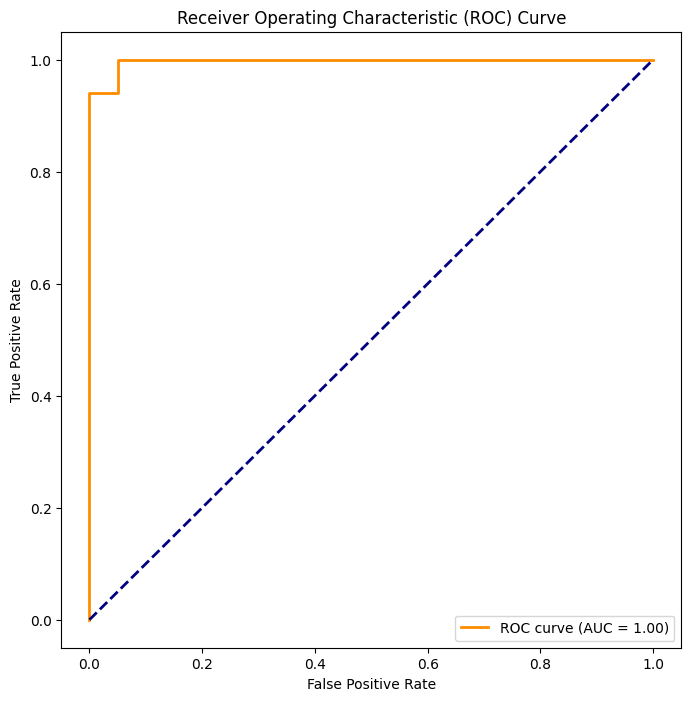

In [31]:
#%%
from sklearn.metrics import roc_curve, auc

# probability estimates for positive class
y_prob = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# plt.savefig('LogReg_Adult_ROC-AUC.pdf', bbox_inches='tight')

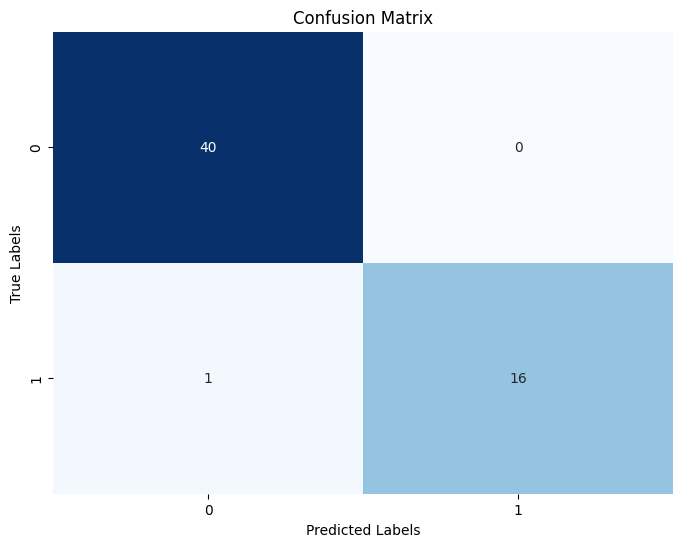

In [32]:
#%%
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# plt.savefig('LogReg_Adult_ConfMat.pdf', bbox_inches='tight')

# Bootstrap

In [35]:
from sklearn.model_selection import KFold

In [37]:
# Number of bootstrap datasets
B = 300
n = X_train.shape[0]

# Storing average validation accuracies for each bootsrap dataset
bootstrap_accuracies = []

# initializing KFold
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=28)

# Non-parametric bootstrap
for b in range(B):
    # Resampling with replacement
    indices = np.random.choice(n, n, replace=True)
    X_b = X_train[indices]
    y_b = y_train[indices]
    
    accuracies = []

    # Loop over folds
    for train_index, val_index in kf.split(X_b):
        X_train_fold, X_val_fold = X_b[train_index], X_b[val_index]
        y_train_fold, y_val_fold = y_b[train_index], y_b[val_index]

        # Training
        model = LogisticRegression(penalty=best_params['penalty'], C=best_params['C'], 
                                   solver='liblinear', max_iter=best_params['max_iter'])
        model.fit(X_train_fold, y_train_fold)

        # Computing accuracy on the validation fold
        accuracy = model.score(X_val_fold, y_val_fold)
        accuracies.append(accuracy)

    # Storing average validation accuracy for this bootstrap dataset
    avg_accuracy = np.mean(accuracies)
    print(f"Average validation accuracy for bootstrap dataset {b} = {avg_accuracy:.3f}")
    bootstrap_accuracies.append(avg_accuracy)

Average validation accuracy for bootstrap dataset 0 = 0.980
Average validation accuracy for bootstrap dataset 1 = 0.973
Average validation accuracy for bootstrap dataset 2 = 0.988
Average validation accuracy for bootstrap dataset 3 = 0.977
Average validation accuracy for bootstrap dataset 4 = 0.984
Average validation accuracy for bootstrap dataset 5 = 0.994
Average validation accuracy for bootstrap dataset 6 = 0.975
Average validation accuracy for bootstrap dataset 7 = 0.982
Average validation accuracy for bootstrap dataset 8 = 0.984
Average validation accuracy for bootstrap dataset 9 = 0.984
Average validation accuracy for bootstrap dataset 10 = 0.986
Average validation accuracy for bootstrap dataset 11 = 0.984
Average validation accuracy for bootstrap dataset 12 = 0.981
Average validation accuracy for bootstrap dataset 13 = 0.980
Average validation accuracy for bootstrap dataset 14 = 0.979
Average validation accuracy for bootstrap dataset 15 = 0.979
Average validation accuracy for bo

In [39]:
# Computing percentiles
mean_acc = np.mean(bootstrap_accuracies)
percentile_5 = np.percentile(bootstrap_accuracies, 5, axis=0)
percentile_95 = np.percentile(bootstrap_accuracies, 95, axis=0)

print("Mean: ", mean_acc)
print("5th percentile: ", percentile_5)
print("95th percentile: ", percentile_95)

Mean:  0.9815115806840536
5th percentile:  0.9725299828669333
95th percentile:  0.9902541404911479
